In [51]:
import pandas as pd
#import ace_tools as tools

import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#import machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance




#import metrics and validation libraries
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix,
                             precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay,auc, classification_report,
                             average_precision_score,accuracy_score,precision_score,recall_score,f1_score,make_scorer)

#import data cleaning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut, GridSearchCV

#Imbalanced dataset library
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE


import seaborn as sns

In [69]:

# Charger le fichier SAS
df = pd.read_stata("D:/Users/33616/Downloads/urban-environment-CH-main/urban-environment-CH-main/data/shp21_p_user.dta",
                   convert_categoricals=False)


df2 = pd.read_csv("urban-environment-CH-main/data/greenery_land_usage_data.csv") 

df = df[["idhous21", "p21c44"]]


# Fusionner sur la colonne "idhous21" en conservant uniquement les correspondances
df_merged = pd.merge(df, df2, on="idhous21", how="inner")

print(df_merged.head(13000))

df_cleaned = df_merged.drop(columns=df_merged.filter(regex="630").columns)
df_cleaned  = df_cleaned [df_cleaned ["p21c44"] >= 0]
df_cleaned["p21c44"] = df_cleaned["p21c44"].apply(lambda x: 0 if x < 8 else 1)


# Afficher le résultat
print(df_cleaned.head())

# Afficher les informations du fichier
print(df_cleaned.info())
print(df_cleaned.describe())
print(df_cleaned.shape)
print(df_cleaned["p21c44"].value_counts())

X = df_cleaned.drop(columns=["p21c44"])  # Toutes les colonnes sauf la cible
y = df_cleaned["p21c44"]  # Variable à prédire
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Visualiser le dataset
#tools.display_dataframe_to_user(name="Dataset Stata", dataframe=df)
print(X_train.shape)






       idhous21  p21c44   pop_density  distance_to_center_1  \
0            51       8  26266.246893           4747.956900   
1            51      -3  26266.246893           4747.956900   
2           131      -3    812.480663           5943.020154   
3           131       9    812.480663           5943.020154   
4           131      -3    812.480663           5943.020154   
...         ...     ...           ...                   ...   
12995    465721      -3   5720.344662           1649.304390   
12996    465721      -3   5720.344662           1649.304390   
12997    465721      -3   5720.344662           1649.304390   
12998    465871       7   1795.469906           2172.483960   
12999    465871       7   1795.469906           2172.483960   

       distance_to_center_2  trees_forest_210  trees_park_210  \
0               4133.256444               0.0        0.189109   
1               4133.256444               0.0        0.189109   
2               5176.860831               0.0   

In [53]:
#Xgboost
XGB = XGBClassifier(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=10,
    reg_alpha=2,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), # Gérer le déséquilibre
    random_state=42
)

XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Display classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[ 636  443]
 [ 728 2147]]
Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.59      0.52      1079
           1       0.83      0.75      0.79      2875

    accuracy                           0.70      3954
   macro avg       0.65      0.67      0.65      3954
weighted avg       0.73      0.70      0.71      3954



Confusion Matrix:
[[ 315  764]
 [ 252 2623]]
Classification Report:
                     0            1  accuracy    macro avg  weighted avg
precision     0.555556     0.774432  0.743045     0.664994      0.714703
recall        0.291937     0.912348  0.743045     0.602142      0.743045
f1-score      0.382746     0.837752  0.743045     0.610249      0.713586
support    1079.000000  2875.000000  0.743045  3954.000000   3954.000000


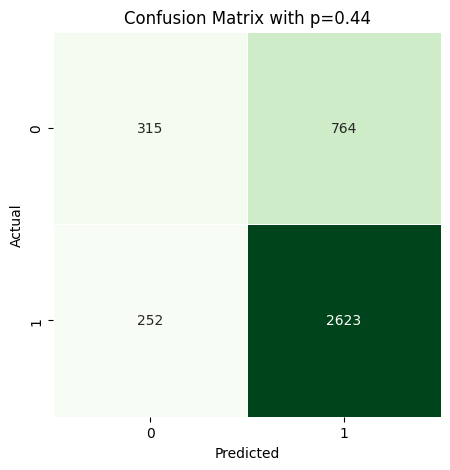

In [54]:
def decision_function(y_proba, threshold):
    return (y_proba > threshold).astype(int)


XGB = XGBClassifier()
XGB.fit(X_train, y_train)


y_proba = XGB.predict_proba(X_test)[:, 1]


y_train_proba = XGB.predict_proba(X_train)[:, 1]


optimal_threshold = 0.44


y_pred = decision_function(y_proba, optimal_threshold)


conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


plt.figure(figsize=(5,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', linewidths=.5, cbar=False)
plt.title('Confusion Matrix with p=0.44')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('XGB_MAT.png',format='png')

class_report = classification_report(y_test, y_pred,output_dict=True)
print("Classification Report:")
class_report
class_report = pd.DataFrame(class_report)
print(class_report)


In [56]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

Classification Report:
Test Set ROC AUC Score: 0.7763549179997582
Test Set PR AUC Score: 0.8942603402781262
Train Set ROC AUC Score: 0.9609106496230608
Train Set PR AUC Score: 0.9859082694640194
Threshold: [0.00116975 0.00215982 0.00291757 ... 0.9998305  0.9999021  1.        ]


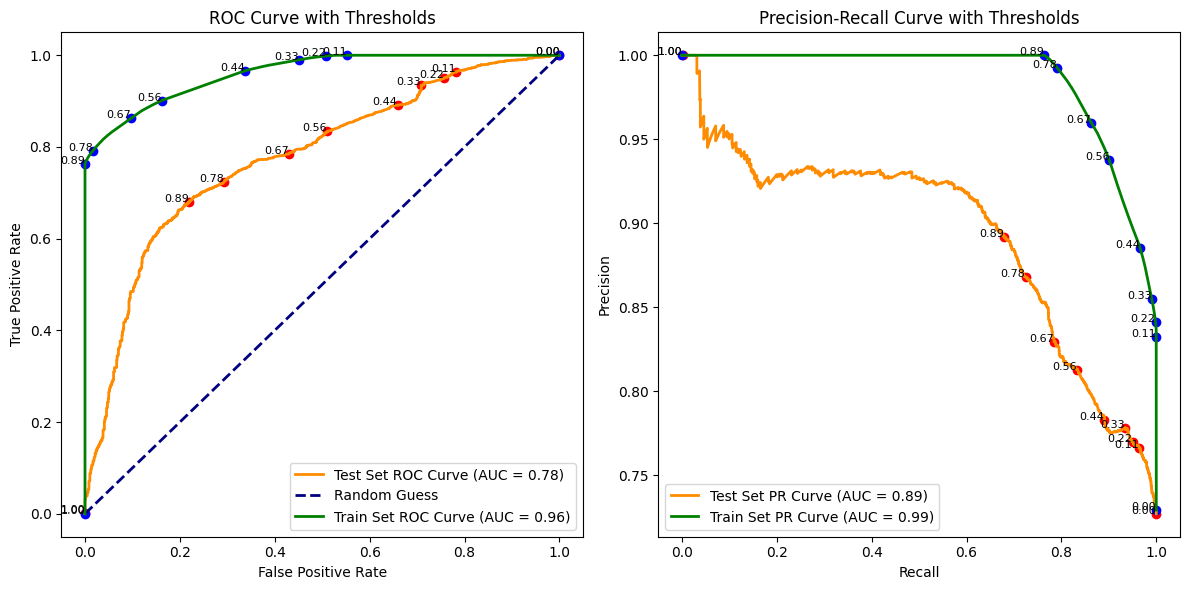

In [63]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

classifier = XGBClassifier(max_depth=6,n_estimators=500)
# Train the classifier on the training data
classifier.fit(X_train, y_train)
class_report = classification_report(y_test, y_pred,output_dict=True)
print("Classification Report:")
class_report

# Make predictions on the test set
y_proba_test = classifier.predict_proba(X_test)[:, 1]
y_proba_train = classifier.predict_proba(X_train)[:, 1]
classifier.fit(X_train, y_train)

# Calculate ROC AUC score for test set
roc_auc_test = roc_auc_score(y_test, y_proba_test)
print("Test Set ROC AUC Score:", roc_auc_test)

# Calculate ROC curve for test set
fpr_test, tpr_test, thresholds_roc_test = roc_curve(y_test, y_proba_test)

# Calculate Precision-Recall curve for test set
precision_test, recall_test, thresholds_pr_test = precision_recall_curve(y_test, y_proba_test)
pr_auc_test = average_precision_score(y_test, y_proba_test)
print("Test Set PR AUC Score:", pr_auc_test)

# Calculate ROC AUC score for train set
roc_auc_train = roc_auc_score(y_train, y_proba_train)
print("Train Set ROC AUC Score:", roc_auc_train)

# Calculate ROC curve for train set
fpr_train, tpr_train, thresholds_roc_train = roc_curve(y_train, y_proba_train)

# Calculate Precision-Recall curve for train set
precision_train, recall_train, thresholds_pr_train = precision_recall_curve(y_train, y_proba_train)
pr_auc_train = average_precision_score(y_train, y_proba_train)
print("Train Set PR AUC Score:", pr_auc_train)
print("Threshold:", thresholds_pr_train )

# Plot ROC curve with thresholds for both train and test sets
plt.figure(figsize=(12, 6))

# Plot ROC curve for test set
plt.subplot(1, 2, 1)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test Set ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Plot thresholds on ROC curve for test set
for i, threshold in enumerate(np.linspace(0, 1, 10)):
    idx = np.argmin(np.abs(thresholds_roc_test - threshold))
    plt.scatter(fpr_test[idx], tpr_test[idx], c='red', marker='o')
    plt.text(fpr_test[idx], tpr_test[idx], f'{threshold:.2f}', fontsize=8, color='black', ha='right')

# Plot ROC curve for train set
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'Train Set ROC Curve (AUC = {roc_auc_train:.2f})')

# Plot thresholds on ROC curve for train set
for i, threshold in enumerate(np.linspace(0, 1, 10)):
    idx = np.argmin(np.abs(thresholds_roc_train - threshold))
    plt.scatter(fpr_train[idx], tpr_train[idx], c='blue', marker='o')
    plt.text(fpr_train[idx], tpr_train[idx], f'{threshold:.2f}', fontsize=8, color='black', ha='right')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Thresholds')
plt.legend(loc='lower right')

# Plot PR curve with thresholds for both train and test sets
plt.subplot(1, 2, 2)
plt.plot(recall_test, precision_test, color='darkorange', lw=2, label=f'Test Set PR Curve (AUC = {pr_auc_test:.2f})')

# Plot thresholds on PR curve for test set
for i, threshold in enumerate(np.linspace(0, 1, 10)):
    idx = np.argmin(np.abs(thresholds_pr_test - threshold))
    plt.scatter(recall_test[idx], precision_test[idx], c='red', marker='o')
    plt.text(recall_test[idx], precision_test[idx], f'{threshold:.2f}', fontsize=8, color='black', ha='right')

# Plot PR curve for train set
plt.plot(recall_train, precision_train, color='green', lw=2, label=f'Train Set PR Curve (AUC = {pr_auc_train:.2f})')

# Plot thresholds on PR curve for train set
for i, threshold in enumerate(np.linspace(0, 1, 10)):
    idx = np.argmin(np.abs(thresholds_pr_train - threshold))
    plt.scatter(recall_train[idx], precision_train[idx], c='blue', marker='o')
    plt.text(recall_train[idx], precision_train[idx], f'{threshold:.2f}', fontsize=8, color='black', ha='right')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve with Thresholds')
plt.legend(loc='lower left')

plt.tight_layout()
plt.savefig('XGBOOST_ROCPR.png',format='png')
plt.show()


              precision    recall  f1-score   support

           0       0.50      0.54      0.52      1079
           1       0.82      0.80      0.81      2875

    accuracy                           0.73      3954
   macro avg       0.66      0.67      0.67      3954
weighted avg       0.74      0.73      0.73      3954

              precision    recall  f1-score      support
0              0.502146  0.542169  0.521390  1079.000000
1              0.822876  0.798261  0.810381  2875.000000
accuracy       0.728376  0.728376  0.728376     0.728376
macro avg      0.662511  0.670215  0.665886  3954.000000
weighted avg   0.735352  0.728376  0.731519  3954.000000


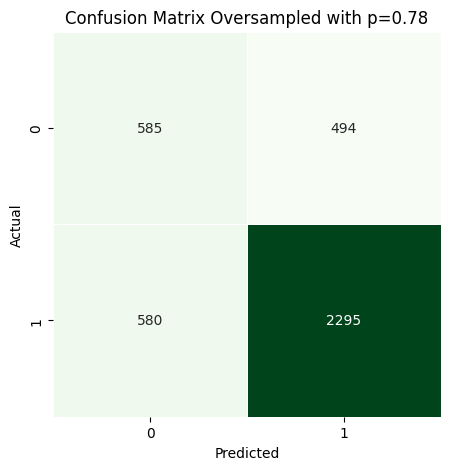

In [58]:
#Random Sampler results

classifier = XGBClassifier(random_state=42)
ROS = RandomOverSampler(random_state = 42)
X_oversampled, y_oversampled = ROS.fit_resample(X_train, y_train)

classifier.fit(X_oversampled,y_oversampled)

y_proba = classifier.predict_proba(X_test)[:,1]

# choose threshold for classification
y_pred = decision_function(y_proba,threshold=0.44)

classf = classification_report(y_test,y_pred)
conf_mat = confusion_matrix(y_test,y_pred)
print(classf)

#export the classification report to latex
report = classification_report(y_test,y_pred,output_dict=True)
report = pd.DataFrame(report).transpose()
print(report)

plt.figure(figsize=(5,5))

sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', linewidths=.5, cbar=False)
plt.title('Confusion Matrix Oversampled with p=0.78')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('XGB_MAT_OVER.png',format='png')
